# Overview

This a notebook that inspects the results of a WarpX simulation.

# Instruction

Enter the path of the data you wish to visualize below. Then execute the cells one by one, by selecting them with your mouse and typing `Shift + Enter`

In [1]:
# Import statements
import yt ; yt.funcs.mylog.setLevel(50)
import numpy as np
import scipy.constants as scc
import matplotlib.pyplot as plt
%matplotlib notebook

#Define the Physical Constants, normalizations, and the scale-down parameter, r_scale, for the pulsar. 

In [2]:
######################
# physical constants #
######################
c = 299792458.0 # speed of light 
q_e = 1.602176634e-19  # elementary charge
me=9.10938356*np.power(10.,-31) # electron mass
epsilon=8.8541878128*np.power(10.,-12) # permittivity of free space
mu_o = 4*3.14*1e-7 # permeability
pi = 3.14159265358979323846
SolarMass = 2e30
G = 6.674e-11 # gravitational constant

#############################################################################
# Parameters for a real Pulsar                                              #
# (Table 7 of J.Petri's article on Theory of Pulsar Magnetosphere and Wind) #
#############################################################################
Omega_real = 6283
B_real = 7.4E4
R_real = 12000
n_real = 6.9e16
omega_pe_real = (n_real*q_e*q_e/(me*epsilon))**0.5 #plasma frequency
SkinDepth_real = c/omega_pe_real 
Mstar = 1.4*SolarMass
Rstar_skinDepth_real = 6e5

##################
# Normalizations #
##################
Rstar_skinDepth = 6e0 # Ratio of radius of star to the skin Depth 
                      # For a real star, this ratio is 6e5
exponent = np.arange(0,6,1)    
Factor = np.array(10**exponent)
Rstar_skinDepth = np.array(6*Factor)  

RLC_Rstar = 4     # Ratio of light cylinder (where the particle speed ~ c) to Rstar
                      # For a pulsar with 1ms period, this ratio is 4. 
                      # i.e., This ratio sets the omega value, since Omega*RLC = c

# Choose skindepth as the free parameter for a choice of normalizations given above
# The skin depth below is computed from the number density for a real pulsar
# Keeping the SkinDepth constant across all the scales in our scaling study
#SkinDepth = 0.02

# Since skin depth is maintained across the scales, and RLC/Rstar is also maintained 
# lets define the decrease in the scale by comparing the value of 
# (Rstar/skinDepth)/(Rstar_real/skinDepth_real)
#r_scale = Rstar_skinDepth/Rstar_skinDepth_real

Rstar = np.ones(6)*12000
SkinDepth = Rstar/Rstar_skinDepth
r_scale = Rstar_skinDepth_real/Rstar_skinDepth

In [3]:
##################################################################
# Derive other physical parameters from the above normalizations #
##################################################################

# 1. Lorentz Boost (dimensionless) #
# Note that in Alex Chen's paper, gamma_o ~ (1/4)*normalized_values.
# Instead here we have pi/2, since that leads to the closes gamma_o 
# value for a real 1ms pulsar. 
gamma_o = (pi/2)*(Rstar_skinDepth)**2/RLC_Rstar 


gamma_real = (pi/2)*6e5**2/RLC_Rstar;
gamma_scaling = gamma_o/(gamma_real) # This is to see how the gamma value 
                      # decreases due to decrease in the ratio of R_star to skin depth



# 3. Light cylinder location (m)
RLC = Rstar*RLC_Rstar
# 4. Angular Frequency (rad/s)
#    Omega remains constant
Omega = c/RLC
# 5. Period (s)
#    Period remains constant
Period = 2*3.14/Omega
# Moment of inertia for a sphere = (2/5)MR^2 (kg.m^2)
# Note that when the Rstar is scaled by r_scale, 
# Mstar decreases as r_scale^3. Thus Mstar*r_scale**3 is the 
# mass of the scaled down star.
# I remains constant across all scales
I = (2/5)*(Mstar)*Rstar**2
# 6. Rotation induced potential drop from pote to equator (V)
#    Reference: Alex Chen's 2014 paper
#    Scales as 1/r_scale**2
phi_o = gamma_o * (me/q_e) * c**2

# Braking is the rate of slow-down of the spin. 
# It is not relevant for the scaling. 
# However, 1e-15 is the P_dot for a pulsar with P=1s
# and the rate of slowdown decreases proportional to the period. 
# So we were to compare two stars with same radius, but different Omega
# then we can use Braking to determine the magnetic field strength at the surface as follows
# Bo = (3*mu_o*c*c*c/(32*pi*pi*pi))**0.5 * (I*Braking*Period)**0.5/(Rstar**3) 
# (Reference : Table 7 of Jetri's article)
# Remains constant across all scales
Braking = 1e-15*Period

# 7. Magnetic field strength (Tesla)
#   Bo decreases as ~ 1/r_scale**2
Bo = phi_o/(Rstar*Rstar*Omega)

# 8. Volume charge density (C/m^3) for uniform magnetization insize the star 
#    Refer to Table 7 of Petri's article 
#    Since Omega increases as r_scale and Bo decreases as r_scale
#    The product of Omega*Bo remains constant across all scales. 
#    Thus, rho_e decreases as (1/r_scale**2)
rho_e = 2*epsilon*Omega*Bo #(Not adding the negative sign here)

# 9. Electron number density (#/m^3)
#    ne decreases as (1/r_scale**2)
ne = rho_e/q_e
# 9a. plasma frequency 
#     decreases as (1/r_scale)
omega_pe = (ne*q_e*q_e/(me*epsilon))**0.5 #plasma frequency
# 10. Magnetic moment (Am^2)
#     decreases as (1/r_scale**2)
magnetic_moment = Bo*Rstar*Rstar*Rstar*4*pi/(mu_o)
# 11. E-field (V/m)
#     Efield decreases as (1/r_scale**2)
E = Omega*Bo*Rstar


#########################################
# How do the energies and forces scale? #
#########################################
# 12. Magnetic Energy (J)
#     Magnetic energy decreases as (1/r_scale**4)
magnetic_energy = (4*pi/3)*Bo**2*Rstar**3/(2*mu_o)

# 13. Gravitational Potential Energy (J)
#     G.pot energy remains constant 
GP_energy = (3/5)*G*Mstar*Mstar/(Rstar)

# 14. Gravitational to Electric force (dimensionless)
#     This ratio increases as r_scale**2
G_EForce = G*Mstar*me/(Rstar*Rstar*q_e*E)

# 15. Rotational kinetic energy 
#     Rot. KE remains constant
rotational_KE = (1/2)*I*Omega**2

# 16. From (12) and (13), we know the B.energy scales as (1/r_scale**4) and GP energy is constant 
#     Thus the ratio of GP_energy and B_energy increases as r_scale**4
GB_energy_ratio = GP_energy/magnetic_energy

# 17. Rate of change of Omega, or angular acceleration decreases as 1/r_scale**4
Omega_dot = Bo*Bo*Rstar**6*Omega**3/(I) * (32*pi/(3*mu_o*c**3))* (1/(4*pi*pi))

# 18. Torque decreases as 1/r_scale**4
Torque = I * Omega_dot


In [4]:
############################################################
# Print all the values that will be used as input in WarpX #
############################################################
print("Input parameters for WarpX for geometry scaled down by r_scale = ", Rstar_skinDepth/Rstar_skinDepth_real)
print("Lorentz factor, (gamma_o) = ", gamma_o)
print("Rstar (m)", Rstar)
print("Omega (rad/s)", Omega)
print("Bo (Tesla)", Bo)
print("ne (/m^3)", ne)
print("Size of the domain, (m)", 30*Rstar)
print("Minimum cell size (m)", SkinDepth)
print("timestep (s)", 0.5*omega_pe**-1) # Or may be cfl criterion
print("Numver of cells assuming unif. grid, ", 30*Rstar/SkinDepth)


Input parameters for WarpX for geometry scaled down by r_scale =  [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
Lorentz factor, (gamma_o) =  [1.41371669e+01 1.41371669e+03 1.41371669e+05 1.41371669e+07
 1.41371669e+09 1.41371669e+11]
Rstar (m) [12000. 12000. 12000. 12000. 12000. 12000.]
Omega (rad/s) [6245.67620833 6245.67620833 6245.67620833 6245.67620833 6245.67620833
 6245.67620833]
Bo (Tesla) [8.03230942e-06 8.03230942e-04 8.03230942e-02 8.03230942e+00
 8.03230942e+02 8.03230942e+04]
ne (/m^3) [5.54482989e+06 5.54482989e+08 5.54482989e+10 5.54482989e+12
 5.54482989e+14 5.54482989e+16]
Size of the domain, (m) [360000. 360000. 360000. 360000. 360000. 360000.]
Minimum cell size (m) [2.e+03 2.e+02 2.e+01 2.e+00 2.e-01 2.e-02]
timestep (s) [3.76386776e-06 3.76386776e-07 3.76386776e-08 3.76386776e-09
 3.76386776e-10 3.76386776e-11]
Numver of cells assuming unif. grid,  [1.8e+02 1.8e+03 1.8e+04 1.8e+05 1.8e+06 1.8e+07]


In [5]:
#############################################################
# Print ratios of G.Pot.Energy/B_energy and G.Force/E_force #
#############################################################
print("Gravitational force to E-force : ", G_EForce)
print("Gravitational energy to B-energy : ",GB_energy_ratio)


# Print dimensional values of energies
print("B energy, (J)",magnetic_energy);
print("Gravitational potential energy, (J)", GP_energy)
print("Rotational Kinetic Energy (J)", rotational_KE )



Gravitational force to E-force :  [1.22562947e-02 1.22562947e-04 1.22562947e-06 1.22562947e-08
 1.22562947e-10 1.22562947e-12]
Gravitational energy to B-energy :  [1.40727411e+38 1.40727411e+34 1.40727411e+30 1.40727411e+26
 1.40727411e+22 1.40727411e+18]
B energy, (J) [1.85906071e+08 1.85906071e+12 1.85906071e+16 1.85906071e+20
 1.85906071e+24 1.85906071e+28]
Gravitational potential energy, (J) [2.616208e+46 2.616208e+46 2.616208e+46 2.616208e+46 2.616208e+46
 2.616208e+46]
Rotational Kinetic Energy (J) [3.14564313e+45 3.14564313e+45 3.14564313e+45 3.14564313e+45
 3.14564313e+45 3.14564313e+45]


<IPython.core.display.Javascript object>


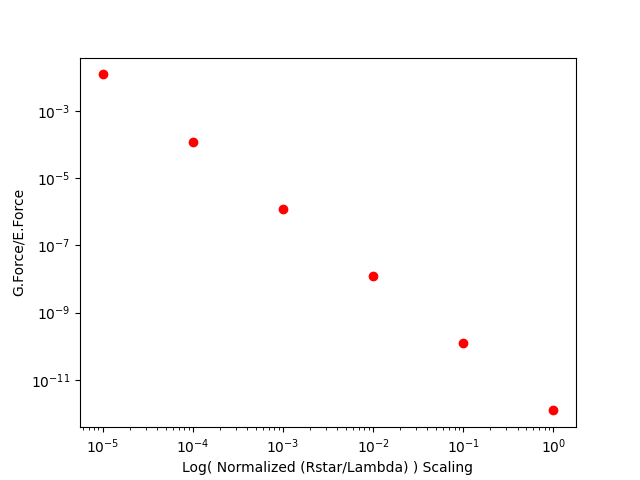

In [6]:
# plot Gravitational force to electric force -- should be constant across all scales

plt.plot(Rstar_skinDepth/6e5,G_EForce,'ro')
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("G.Force/E.Force")
plt.xscale("log")
plt.yscale("log")
plt.savefig("G_Eforce_scaling.png",bbox_inches='tight')
#plt.show()

In [7]:
# plot Gravitational to magnetic energy -- should be constant across all scales

plt.plot(Rstar_skinDepth/6e5,GB_energy_ratio,'ro')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("G.Energy/B.energy")
plt.xscale("log")
plt.yscale("log")
plt.savefig("G_Benergy_scaling.png",bbox_inches='tight')
#plt.show()

In [8]:
# Trends of all energies
plt.plot(Rstar_skinDepth/6e5,magnetic_energy,color="red",ls='--',lw=2,marker="^",markersize=8)
plt.plot(Rstar_skinDepth/6e5,GP_energy,color="blue",lw=2,marker='o',markersize=8,markerfacecolor='blue')
plt.plot(Rstar_skinDepth/6e5,rotational_KE,color="purple",lw=2,marker='s',markersize=8,markeredgecolor='purple')
plt.plot(Rstar_skinDepth/6e5,Torque,color="cyan",lw=2,marker='>',markersize=8,markeredgecolor='purple')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("Energy (J)")
plt.xscale("log")
plt.yscale("log")
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.legend(["Magnetic","G. Potential","Rotational KE","Torque"],loc=2,fontsize='small',frameon="false",borderpad=0.1)
plt.ylim([1e0,1e90])
plt.savefig("Energy_scaling.png",bbox_inches='tight')
plt.show()

In [9]:
# plot Gravitational to magnetic energy -- should be constant across all scales
plt.plot(Rstar_skinDepth/6e5,Bo/Bo[5],color="blue",lw=2,marker='s',markersize=8)
plt.ylabel("Normalized B. field",color="blue")
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.yticks(color="blue")
plt.xscale("log")
plt.yscale("log")
plt.twinx()
plt.plot(Rstar_skinDepth/6e5,Omega/Omega[5],color="red",lw=2,marker='o',markersize=8)
plt.ylabel("Normalized \u03A9",color="red")
plt.yticks(color="red")
plt.xscale("log")
plt.ylim([0,2])
plt.savefig("Normalized_B_Omega.png",bbox_inches='tight')
plt.show()

In [10]:
plt.plot(Rstar_skinDepth/6e5,gamma_o,'ro')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("Normalized G.Energy/B.energy")
plt.xscale("log")
plt.yscale("log")
plt.savefig("G_Benergy_scaling.png",bbox_inches='tight')
#plt.show()

In [11]:
plt.plot(Rstar_skinDepth/6e5,Omega_dot,'ro')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("Omega_dot")
plt.xscale("log")
plt.yscale("log")
plt.savefig("G_Benergy_scaling.png",bbox_inches='tight')
#plt.show()

In [12]:
plt.plot(Rstar_skinDepth/6e5,Torque,'ro')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("Torque")
plt.xscale("log")
plt.yscale("log")
plt.savefig("Torque.png",bbox_inches='tight')
plt.show()

In [13]:
plt.plot(Rstar_skinDepth/6e5,phi_o,'ro')
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
plt.xlabel("Log( Normalized (Rstar/Lambda) ) Scaling")
plt.ylabel("Normalized G.Energy/B.energy")
plt.xscale("log")
plt.yscale("log")
plt.savefig("phi_o.png",bbox_inches='tight')
plt.show()

In [14]:
SkinDepth_real

0.020230407144897423

In [15]:
RLC


array([48000., 48000., 48000., 48000., 48000., 48000.])

In [16]:
36000/256

140.625

In [17]:
particle_weight = 140.625**3*5.544e6/64

In [18]:
particle_weight

240896701812.74414

In [19]:
Period

array([0.0010055, 0.0010055, 0.0010055, 0.0010055, 0.0010055, 0.0010055])

In [20]:
RLC


array([48000., 48000., 48000., 48000., 48000., 48000.])